In [24]:
# %%
# %%
# !pip install pandas numpy matplotlib lifelines

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import os
from config import DATA_ROOT

# Make plots look a bit nicer
plt.rcParams.update({'font.size': 18, 'figure.figsize': (10, 6)})
# plt.style.use("default")

# %%
# 1. Read CSV
# --------------------------------------------------------------------
# Set CSV path here:

csv_path = os.path.join(DATA_ROOT, "original_data.csv")  #

df_raw = pd.read_csv(csv_path)

print("Raw shape:", df_raw.shape)
df_raw.head()
# ---- compute PRS time ----
df = df_raw.copy()

Raw shape: (272, 120)


In [25]:
csv_path = os.path.join(DATA_ROOT, "original_data.xlsx")  
df_raw = pd.read_excel(csv_path)
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (272, 120)


,b,#,Center,by,Date of first diagnosis (date of first surgery),Age at diagnosis,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,Additional experimental treatment (yes: please specify/no).2,Bevacizumab (yes/no).1,Death (1: yes / 0: no),Date of death or last follow-up,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression
0,1,2,"PGIMER, Chandigarh, India",SRS,2021-04-05,56.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,0,2025-03-21,35.333333,48.200000,12.866667,9.200000,3.666667,9.200000
1,2,3,"PGIMER, Chandigarh, India",SRS,2018-08-10,38.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,0,2024-09-18,17.900000,74.366667,56.466667,55.766667,0.700000,55.766667
2,3,1,Dokkyo Medical Universiry,SRS,2015-02-23,47.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,1,2015-10-22,4.800000,8.033333,3.233333,2.833333,0.400000,2.833333
3,4,7,Dokkyo Medical Universiry,SRS,2016-02-05,74.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,1,2017-09-16,9.466667,19.633333,10.166667,9.033333,1.133333,9.033333
4,5,13,Dokkyo Medical Universiry,SRS,2017-06-28,75.0,M,Glioblastoma,WT,NaN,...,NaN,NaN,0,2020-11-06,25.733333,40.900000,15.166667,14.766667,0.400000,14.766667


In [26]:
# Time points for survival analysis
# Time points for survival analysis
time_points = ["Date of first recurrence per RANO (date of MRI)",
"Date of death or last follow-up"]

# Variables needed
variables = ["Age at diagnosis",
"KPS before SRS or re-RT for Recurrence",
"Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)",
"SRS Dose (Gy)",
] # "MGMT (methyl/unmethyl/n.a.)"
# create mapping from original column names to standardized names
col_mapping = {
    "Date of first recurrence per RANO (date of MRI)": "recurrence_date",
    "Date of death or last follow-up": "death_or_lastFU_date",
    "Death (1: yes / 0: no)": "event_death",
    "Age at diagnosis": "age_dx",
    "KPS before SRS or re-RT for Recurrence": "kps_pre",
    "Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)": "ce_volume_cm3",
    "SRS Dose (Gy)": "srs_dose_gy"
}

df = df.rename(columns=col_mapping)

time_points = [col_mapping[tp] for tp in time_points]
variables = [col_mapping[var] for var in variables]

# read in variables
# df = df[time_points + variables].copy()
for col in time_points:
    # check if there is any missing data
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
# add a new column to calculate survival time
df["Survival Time (days)"] = (pd.to_datetime(df["death_or_lastFU_date"]) - pd.to_datetime(df["recurrence_date"])).dt.days

for col in variables:
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
    # if missing, fill with median or mode
    if df[col].dtype in [np.float64, np.int64]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# read a survival event column
df["Event Observed"] = df_raw["Death (1: yes / 0: no)"].astype(bool)
missing_count = df["Event Observed"].isnull().sum()
print(f"Missing values in 'Event Observed': {missing_count}")

# survival time prediction
df = df[df["Survival Time (days)"] >= 0]  # remove negative survival times
print("Processed shape:", df.shape)

# use survivaltree to predict survival


df.head()



Missing values in 'recurrence_date': 0
Missing values in 'death_or_lastFU_date': 0
Missing values in 'age_dx': 0
Missing values in 'kps_pre': 5
Missing values in 'ce_volume_cm3': 16
Missing values in 'srs_dose_gy': 1
Missing values in 'Event Observed': 0
Processed shape: (272, 122)


/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_89230/757976520.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Survival Time (days)"] = (pd.to_datetime(df["death_or_lastFU_date"]) - pd.to_datetime(df["recurrence_date"])).dt.days
/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_89230/757976520.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Survival Time (days)"] = (pd.to_datetime(df["death_or_lastFU_date"]) - pd.to_datetime(df["recurrence_date"])).dt.days
/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_89230/757976520.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The beha

,b,#,Center,by,Date of first diagnosis (date of first surgery),age_dx,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,event_death,death_or_lastFU_date,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression,Survival Time (days),Event Observed
0,1,2,"PGIMER, Chandigarh, India",SRS,04/2021,56,F,Glioblastoma,WT,NaN,...,0,03/2025,35.3,48.2,12.9,9.2,3.7,9.2,394,False
1,2,3,"PGIMER, Chandigarh, India",SRS,08/2018,38,M,Glioblastoma,WT,NaN,...,0,09/2024,17.9,74.4,56.5,55.8,0.7,55.8,1705,False
2,3,1,Dokkyo Medical Universiry,SRS,02/2015,47,F,Glioblastoma,WT,NaN,...,1,10/2015,4.8,8.0,3.2,2.8,0.4,2.8,92,True
3,4,7,Dokkyo Medical Universiry,SRS,02/2016,74,M,Glioblastoma,WT,NaN,...,1,09/2017,9.5,19.6,10.2,9.0,1.1,9.0,304,True
4,5,13,Dokkyo Medical Universiry,SRS,06/2017,75,M,Glioblastoma,WT,NaN,...,0,11/2020,25.7,40.9,15.2,14.8,0.4,14.8,458,False


'''
create a model to predictive PRS(post-recurrence survival) in patients, the PRS survival time is defined as the time from recurrence to death
 recurrence: "Date of first recurrence per RANO (date of MRI)", death: "Date of death or last follow-up". variables can be used "Age at diagnosis,
KPS before SRS or re-RT for Recurrence,
Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis),
SRS Dose (Gy)"
'''

In [27]:
from sksurv.util import Surv
from sksurv.tree import SurvivalTree
from sksurv.metrics import concordance_index_censored



#
# Prepare data for survival tree
y_structured = Surv.from_dataframe("Event Observed", "Survival Time (days)", df)
X = df[variables]
# Fit survival tree

min_samples_leaf = 25
min_samples_split = 50
max_depth = 2

surv_tree = SurvivalTree(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
surv_tree.fit(X, y_structured)
# Predict risk scores
# risk_scores = -surv_tree.predict(X)  # negative because higher risk should correspond to lower survival
risk_scores = surv_tree.predict(X)  # negative because higher risk should correspond to lower survival



In [28]:
from sklearn.tree import plot_tree
import graphviz
from sklearn.tree import export_graphviz

# # 2. Plot the tree
# plt.figure(figsize=(15, 10))
# plot_tree(
#     surv_tree, 
#     feature_names=X.columns, 
#     filled=True, 
#     rounded=True, 
#     fontsize=10
# )
# plt.title("RPA Stratification Tree")
# plt.show()

In [29]:
print(surv_tree.tree_)

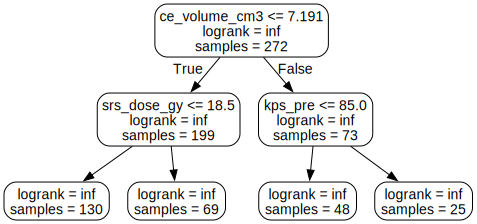

In [30]:
import re
surv_tree.criterion = "logrank" 

# 2. Export the tree structure to DOT format
dot_data = export_graphviz(
    surv_tree,
    out_file=None,
    feature_names=X.columns,
    filled=False, # Must be False to prevent the float NaN error
    rounded=True
)

# 3. Render and view the tree
# dot_data_cleaned = re.sub(r'value\s*=\s*\[.*?\][^\n]*\n', '', dot_data, flags=re.DOTALL)

cleaned_lines = []
for line in dot_data.split('\n'):
    # Check if the line contains the "value =" string
    # print(line)
    if "value =" in line:
        # print(line)
        idx_value = line.index("value =") -2
        idx_last_bracket = line.rindex("]")-2
        # print(len(line))
        # print(idx_value, idx_last_bracket)
        cleaned_lines.append(line[:idx_value] + line[idx_last_bracket+1:])
        # print(cleaned_lines[-1])
        # break
    else:
        cleaned_lines.append(line)
dot_data_manual = '\n'.join(cleaned_lines)

# print(dot_data_manual)

graph = graphviz.Source(dot_data_manual)
graph.render("./survival_tree.pdf")  # Saves as survival_tree.pdf
graph  # Displays in Jupyter/Colab

In [31]:
# use clinical cutoff to define leaf nodes and compute average risk score for each leaf node
#  round numbers 7.2 for volume, 19 Gy for dose, and KPS of 80
leaf_130 = X.index[(X["ce_volume_cm3"] <= 7.2) & (X["srs_dose_gy"] <= 19)]
leaf_69  = X.index[(X["ce_volume_cm3"] <= 7.2) & (X["srs_dose_gy"] >  19)]
leaf_48  = X.index[(X["ce_volume_cm3"] >  7.2) & (X["kps_pre"]     <= 80.0)]
leaf_25  = X.index[(X["ce_volume_cm3"] >  7.2) & (X["kps_pre"]     >  80.0)]

leaf_A_idx = leaf_130
leaf_B_idx = leaf_69
leaf_C_idx = leaf_48
leaf_D_idx = leaf_25

leaf_130_risk_scores = risk_scores[leaf_130]
leaf_69_risk_scores  = risk_scores[leaf_69]
leaf_48_risk_scores  = risk_scores[leaf_48]
leaf_25_risk_scores  = risk_scores[leaf_25]

print("Average risk score for Leaf 130:", leaf_130_risk_scores.mean(), "standard deviation:", leaf_130_risk_scores.std())
print("Average risk score for Leaf 69:", leaf_69_risk_scores.mean(), "standard deviation:", leaf_69_risk_scores.std())
print("Average risk score for Leaf 48:", leaf_48_risk_scores.mean(), "standard deviation:", leaf_48_risk_scores.std())
print("Average risk score for Leaf 25:", leaf_25_risk_scores.mean(), "standard deviation:", leaf_25_risk_scores.std())
# create a dictionary to map leaf node to risk score
leaf_risk_dict = {
    "Leaf 130": leaf_130_risk_scores,
    "Leaf 69":  leaf_69_risk_scores,
    "Leaf 48":  leaf_48_risk_scores,
    "Leaf 25":  leaf_25_risk_scores
}

Average risk score for Leaf 130: 125.07838518107746 standard deviation: 6.744193304819529
Average risk score for Leaf 69: 80.68266979749406 standard deviation: 0.0
Average risk score for Leaf 48: 232.27095592415455 standard deviation: 0.0
Average risk score for Leaf 25: 144.21917298074123 standard deviation: 0.0


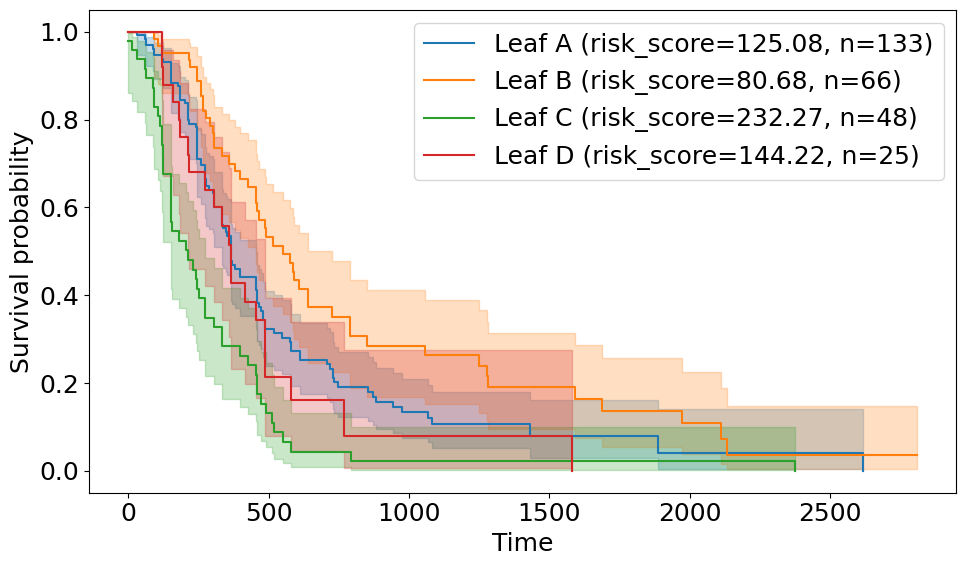

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

# X: DataFrame of features (index = sample id)
# time: Series/array of survival time (same order as X)
# event: Series/array of event indicator (1=event/death, 0=censored)

time = pd.Series(y_structured["Survival Time (days)"], index=X.index)
event = pd.Series(y_structured["Event Observed"], index=X.index)

# ---- define leaves (use your tree’s split rules) ----
leaves = {
    "Leaf A: ce<=7.2 & dose<=19": (X["ce_volume_cm3"] <= 7.2) & (X["srs_dose_gy"] <= 19),
    "Leaf B: ce<=7.2 & dose>19" : (X["ce_volume_cm3"] <= 7.2) & (X["srs_dose_gy"] >  19),
    "Leaf C: ce>7.2 & kps<=80"    : (X["ce_volume_cm3"] >  7.2) & (X["kps_pre"]      <= 80.0),
    "Leaf D: ce>7.2 & kps>80"     : (X["ce_volume_cm3"] >  7.2) & (X["kps_pre"]      >  80.0),
}

# map leaf_risk_dict keys to leaves keys
leaf_risk_dict_mapped = {
    "Leaf A: ce<=7.2 & dose<=19": leaf_risk_dict["Leaf 130"],
    "Leaf B: ce<=7.2 & dose>19" : leaf_risk_dict["Leaf 69"],
    "Leaf C: ce>7.2 & kps<=80"    : leaf_risk_dict["Leaf 48"],
    "Leaf D: ce>7.2 & kps>80"     : leaf_risk_dict["Leaf 25"],
} 

# ---- plot KM curves ----
kmf = KaplanMeierFitter()
plt.figure()

groups = []
for name, m in leaves.items():
    ids = X.index[m]
    groups.append(pd.Series(name, index=ids))
    # retrieve risk scores for these ids
    risk_scores_leaf = leaf_risk_dict_mapped[name]
    leaf_name = name.split(":")[0]
    label = f"{leaf_name} (risk_score={risk_scores_leaf.mean():.2f}, n={len(ids)})"
    kmf.fit(durations=time.loc[ids], event_observed=event.loc[ids], label=label)
    kmf.plot(ci_show=True)

plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.legend()
plt.tight_layout()
plt.show()




In [33]:
# ---- optional: overall log-rank test across all leaves ----
group_labels = pd.concat(groups)  # Series indexed by sample id -> group name
res = multivariate_logrank_test(time.loc[group_labels.index], group_labels, event.loc[group_labels.index])
print("Overall log-rank p-value:", res.p_value)

Overall log-rank p-value: 1.3537967845986613e-07


In [34]:
# --- log-rank p-value (this part is fine) ---
results_AB = logrank_test(
    time.loc[leaf_A_idx], time.loc[leaf_B_idx],
    event_observed_A=event.loc[leaf_A_idx],
    event_observed_B=event.loc[leaf_B_idx]
)
p_AB = results_AB.p_value

# --- HR via Cox model ---
df_AB = pd.DataFrame({
    "T": pd.concat([time.loc[leaf_A_idx], time.loc[leaf_B_idx]]).astype(float),
    "E": pd.concat([event.loc[leaf_A_idx], event.loc[leaf_B_idx]]).astype(int),
    "group": np.r_[np.zeros(time.loc[leaf_A_idx].shape[0]), np.ones(time.loc[leaf_B_idx].shape[0])]
})
# group=0 => Leaf A (reference)
# group=1 => Leaf B

cph = CoxPHFitter()
cph.fit(df_AB, duration_col="T", event_col="E", formula="group")

hr_AB = float(np.exp(cph.params_["group"]))  # hazard ratio Leaf B vs Leaf A
ci_AB = cph.confidence_intervals_.loc["group"].values
ci_AB = tuple(np.exp(ci_AB))  # convert log-HR CI to HR CI

print(f"Log-rank p = {p_AB:.4g}")
print(f"HR (Leaf B vs Leaf A) = {hr_AB:.3f} (95% CI {ci_AB[0]:.3f}–{ci_AB[1]:.3f})")

Log-rank p = 0.008457
HR (Leaf B vs Leaf A) = 0.628 (95% CI 0.444–0.889)


In [35]:
# --- log-rank p-value (this part is fine) ---
results_CD = logrank_test(
    time.loc[leaf_C_idx], time.loc[leaf_D_idx],
    event_observed_C=event.loc[leaf_C_idx],
    event_observed_D=event.loc[leaf_D_idx]
)
p_CD = results_CD.p_value

# --- HR via Cox model ---
df_CD = pd.DataFrame({
    "T": pd.concat([time.loc[leaf_C_idx], time.loc[leaf_D_idx]]).astype(float),
    "E": pd.concat([event.loc[leaf_C_idx], event.loc[leaf_D_idx]]).astype(int),
    "group": np.r_[np.zeros(time.loc[leaf_C_idx].shape[0]), np.ones(time.loc[leaf_D_idx].shape[0])]
})
# group=0 => Leaf C (reference)
# group=1 => Leaf D

cph = CoxPHFitter()
cph.fit(df_CD, duration_col="T", event_col="E", formula="group")

hr_CD = float(np.exp(cph.params_["group"]))  # hazard ratio Leaf D vs Leaf C
ci_CD = cph.confidence_intervals_.loc["group"].values
ci_CD = tuple(np.exp(ci_CD))  # convert log-HR CI to HR CI

print(f"Log-rank p = {p_CD:.4g}")
print(f"HR (Leaf D vs Leaf C) = {hr_CD:.3f} (95% CI {ci_CD[0]:.3f}–{ci_CD[1]:.3f})")

Log-rank p = 0.0847
HR (Leaf D vs Leaf C) = 0.606 (95% CI 0.363–1.011)


# merge data from leaf A and leaf D, and do analysis

Average risk score for Leaf A+D: 128.10699084558127 standard deviation: 9.331920021761887


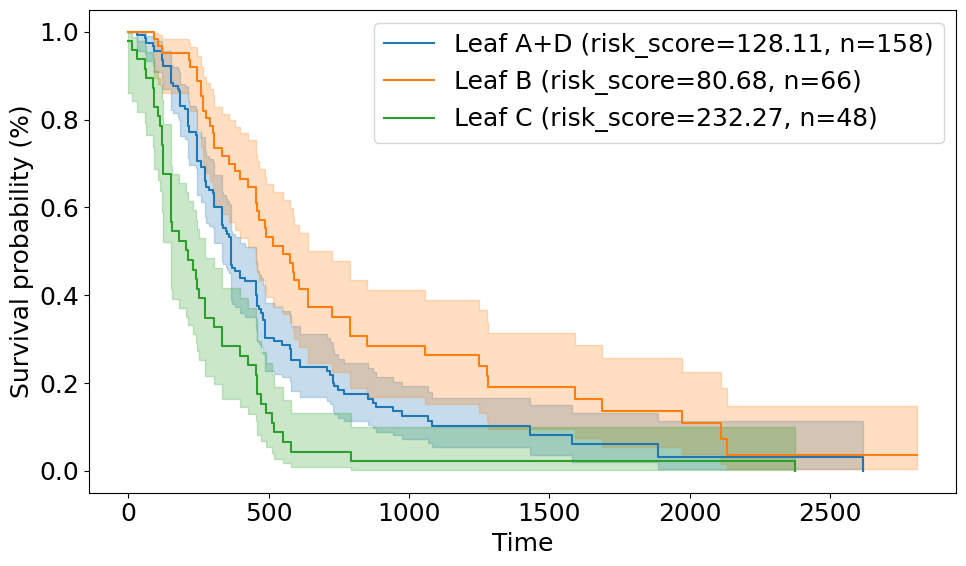

In [36]:
# merge data from leaf A and leaf D, and plot KM curve again
leaf_A_D_idx = X.index[(leaves["Leaf A: ce<=7.2 & dose<=19"]) | (leaves["Leaf D: ce>7.2 & kps>80"])]
leaf_A_D_risk_scores = risk_scores[leaf_A_D_idx]
print("Average risk score for Leaf A+D:", leaf_A_D_risk_scores.mean(), "standard deviation:", leaf_A_D_risk_scores.std())
# %%
# plot KM curve for leaf A+D, leaf B and leaf C
kmf = KaplanMeierFitter()
plt.figure()
groups = []
# Leaf A+D
groups.append(pd.Series("Leaf A+D", index=leaf_A_D_idx))
label = f"Leaf A+D (risk_score={leaf_A_D_risk_scores.mean():.2f}, n={len(leaf_A_D_idx)})"
kmf.fit(durations=time.loc[leaf_A_D_idx], event_observed=event.loc[leaf_A_D_idx], label=label)
kmf.plot(ci_show=True)
# Leaf B
leaf_B_idx = X.index[leaves["Leaf B: ce<=7.2 & dose>19"]]
groups.append(pd.Series("Leaf B", index=leaf_B_idx))
risk_scores_leaf_B = leaf_risk_dict_mapped["Leaf B: ce<=7.2 & dose>19"]
label = f"Leaf B (risk_score={risk_scores_leaf_B.mean():.2f}, n={len(leaf_B_idx)})"
kmf.fit(durations=time.loc[leaf_B_idx], event_observed=event.loc[leaf_B_idx], label=label)
kmf.plot(ci_show=True)
# Leaf C
leaf_C_idx = X.index[leaves["Leaf C: ce>7.2 & kps<=80"]]
groups.append(pd.Series("Leaf C", index=leaf_C_idx))
risk_scores_leaf_C = leaf_risk_dict_mapped["Leaf C: ce>7.2 & kps<=80"]
label = f"Leaf C (risk_score={risk_scores_leaf_C.mean():.2f}, n={len(leaf_C_idx)})"
kmf.fit(durations=time.loc[leaf_C_idx], event_observed=event.loc[leaf_C_idx], label=label)
kmf.plot(ci_show=True)      
plt.xlabel("Time")
plt.ylabel("Survival probability (%)")
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
# number of events in each group
for name, m in [("Leaf A+D", leaf_A_D_idx), ("Leaf B", leaf_B_idx), ("Leaf C", leaf_C_idx)]:
    n_events = event.loc[m].sum()
    n_total = len(m)
    print(f"{name}: {n_events} events out of {n_total} patients")

Leaf A+D: 127 events out of 158 patients
Leaf B: 48 events out of 66 patients
Leaf C: 46 events out of 48 patients


Average risk score for Leaf A+D: 128.10699084558127 standard deviation: 9.331920021761887
Overall log-rank p-value: 4.318924331298444e-08


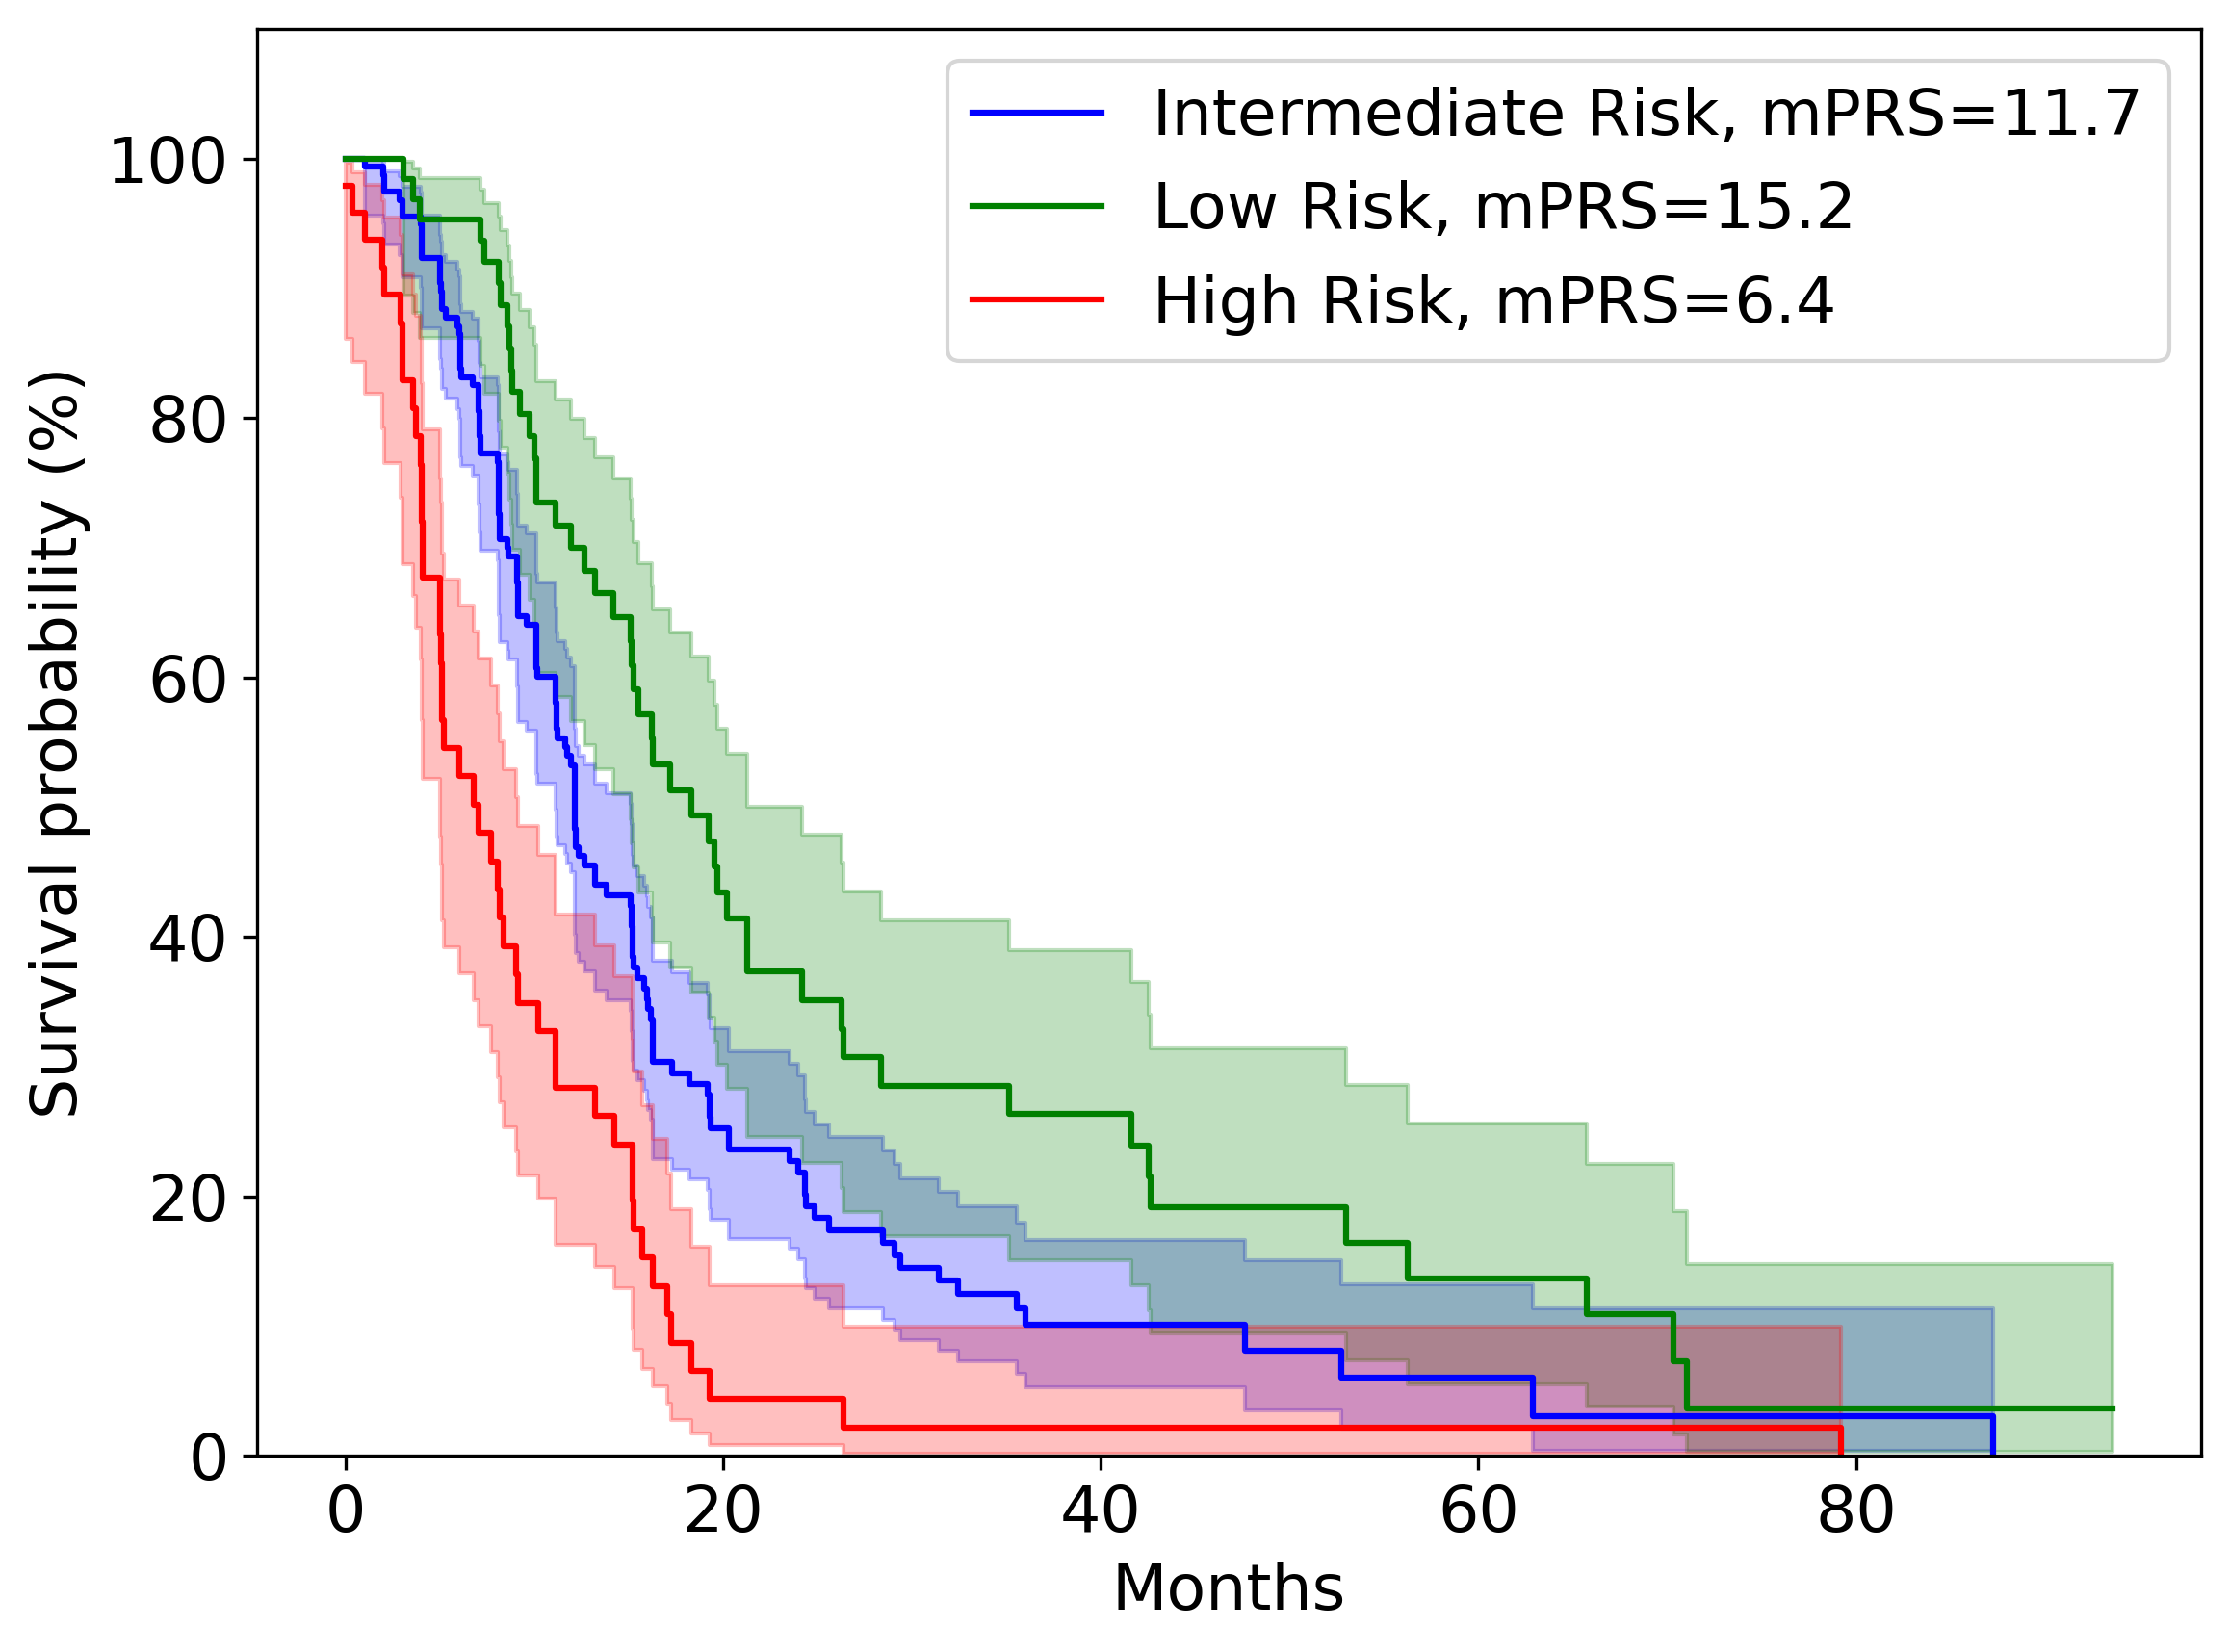

In [38]:
# Plot for publication
plt.rcParams.update({'font.size': 16, 'figure.figsize': (8, 6)})

# merge data from leaf A and leaf D, and plot KM curve again
leaf_A_D_idx = X.index[(leaves["Leaf A: ce<=7.2 & dose<=19"]) | (leaves["Leaf D: ce>7.2 & kps>80"])]
leaf_A_D_risk_scores = risk_scores[leaf_A_D_idx]
print("Average risk score for Leaf A+D:", leaf_A_D_risk_scores.mean(), "standard deviation:", leaf_A_D_risk_scores.std())
# %%
# plot KM curve for leaf A+D, leaf B and leaf C
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6), dpi=300)
groups = []
# Leaf A+D
PRS_AD = pd.Series(df["Survival Time (days)"], index=leaf_A_D_idx)/30.0
median_PRS_AD = np.median(PRS_AD)
groups.append(pd.Series("Leaf A+D", index=leaf_A_D_idx))
# label = f"Intermediate Risk, n={len(leaf_A_D_idx)}, mPRS={median_PRS_AD:.1f}"
label = f"Intermediate Risk, mPRS={median_PRS_AD:.1f}"
kmf.fit(durations=time.loc[leaf_A_D_idx]/30, event_observed=event.loc[leaf_A_D_idx], label=label)
kmf.plot(ci_show=True, color='blue')
# Leaf B
leaf_B_idx = X.index[leaves["Leaf B: ce<=7.2 & dose>19"]]
PRS_B = pd.Series(df["Survival Time (days)"], index=leaf_B_idx)/30.0
median_PRS_B = np.median(PRS_B)
groups.append(pd.Series("Leaf B", index=leaf_B_idx))
risk_scores_leaf_B = leaf_risk_dict_mapped["Leaf B: ce<=7.2 & dose>19"]
# label = f"Low Risk, n={len(leaf_B_idx)}, mPRS={median_PRS_B:.1f}"
label = f"Low Risk, mPRS={median_PRS_B:.1f}"
kmf.fit(durations=time.loc[leaf_B_idx]/30, event_observed=event.loc[leaf_B_idx], label=label)
kmf.plot(ci_show=True, color='green')
# Leaf C
leaf_C_idx = X.index[leaves["Leaf C: ce>7.2 & kps<=80"]]
PRS_C = pd.Series(df["Survival Time (days)"], index=leaf_C_idx)/30.0
median_PRS_C = np.median(PRS_C)
groups.append(pd.Series("Leaf C", index=leaf_C_idx))
risk_scores_leaf_C = leaf_risk_dict_mapped["Leaf C: ce>7.2 & kps<=80"]
# label = f"High Risk, n={len(leaf_C_idx)}, mPRS={median_PRS_C:.1f}"
label = f"High Risk, mPRS={median_PRS_C:.1f}"
kmf.fit(durations=time.loc[leaf_C_idx]/30, event_observed=event.loc[leaf_C_idx], label=label)
kmf.plot(ci_show=True, color='red')      

# calcualte the log-rank test p-value, comparing the survival curves across all groups simultaneously.
group_labels = pd.concat(groups)  # Series indexed by sample id -> group name
res = multivariate_logrank_test(time.loc[group_labels.index]/30, group_labels, event.loc[group_labels.index])
print("Overall log-rank p-value:", res.p_value) 
##################################
# add p-value annotations here 

##################################
plt.xlabel("Months")
yticks = plt.yticks()[0]
plt.yticks(yticks, (yticks * 100).astype(int))
plt.ylim(0, 1.1)
plt.ylabel("Survival probability (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [39]:

# Get the number at risk at 0, 20,40,60 and 80 months for each risk group
# save as a table
time_checkpoints = [0, 20*30, 40*30, 60*30, 80*30]  # in days
df_results = pd.DataFrame(columns=["risk_group", "0 months", "20 months", "40 months", "60 months", "80 months"])

# now, calculate the number at risk at each time point for each group
n_at_risk = {}
leaf_A_idx = X.index[leaves["Leaf A: ce<=7.2 & dose<=19"]]
leaf_B_idx = X.index[leaves["Leaf B: ce<=7.2 & dose>19"]]
leaf_C_idx = X.index[leaves["Leaf C: ce>7.2 & kps<=80"]]
leaf_D_idx = X.index[leaves["Leaf D: ce>7.2 & kps>80"]]

n_at_risk["low"] = len(leaf_B_idx)
n_at_risk["intermediate"] = len(leaf_A_idx) + len(leaf_D_idx)
n_at_risk["high"] = len(leaf_C_idx) 





# # leaf B survival counts at time checkpoints
# kmf.fit(durations=time.loc[leaf_B_idx], event_observed=event.loc[leaf_B_idx], label="Leaf B")
# surv_probs = kmf.survival_function_at_times(time_checkpoints).values
# n_at_risk = len(leaf_B_idx)
# n_survived = (surv_probs * n_at_risk).astype(int)   
# # n_survived = n_at_risk
# df_results = pd.concat([df_results, pd.DataFrame([{
#     # "Leaf": "Leaf B",
#     "risk_group": "low",
#     "0 months": n_survived[0],
#     "20 months": n_survived[1],
#     "40 months": n_survived[2],
#     "60 months": n_survived[3],
#     "80 months": n_survived[4],
# }])], ignore_index=True)
# # leaf_A_D survival counts at time checkpoints

# kmf.fit(durations=time.loc[leaf_A_D_idx], event_observed=event.loc[leaf_A_D_idx], label="Leaf A+D")
# surv_probs = kmf.survival_function_at_times(time_checkpoints).values
# n_at_risk = len(leaf_A_D_idx)
# n_survived = (surv_probs * n_at_risk).astype(int)
# # n_survived = n_at_risk
# df_results = pd.concat([df_results, pd.DataFrame([{
#     # "Leaf": "Leaf A+D",
#     "risk_group": "intermediate",
#     "0 months": n_survived[0],
#     "20 months": n_survived[1],
#     "40 months": n_survived[2],
#     "60 months": n_survived[3], 
#     "80 months": n_survived[4],
# }])], ignore_index=True)

# # leaf C survival counts at time checkpoints
# kmf.fit(durations=time.loc[leaf_C_idx], event_observed=event.loc[leaf_C_idx], label="Leaf C")
# surv_probs = kmf.survival_function_at_times(time_checkpoints).values
# n_at_risk = len(leaf_C_idx)    
# n_survived = (surv_probs * n_at_risk).astype(int)
# # n_survived = n_at_risk
# df_results = pd.concat([df_results, pd.DataFrame([{
#     # "Leaf": "Leaf C",
#     "risk_group": "high",
#     "0 months": n_survived[0],
#     "20 months": n_survived[1],
#     "40 months": n_survived[2],
#     "60 months": n_survived[3],
#     "80 months": n_survived[4],
# }])], ignore_index=True)    
# # save to csv    
# df_results.to_csv("survived_samples_by_time.csv", index=False)
# df_results


In [40]:
# Get the number of survivals at 20,40,60 and 80 months for each risk group
# save as a table
time_checkpoints = [0, 20*30, 40*30, 60*30, 80*30]  # in days
df_results = pd.DataFrame(columns=["risk_group", "0 months", "20 months", "40 months", "60 months", "80 months"])
# leaf B survival counts at time checkpoints
kmf.fit(durations=time.loc[leaf_B_idx], event_observed=event.loc[leaf_B_idx], label="Leaf B")
surv_probs = kmf.survival_function_at_times(time_checkpoints).values
n_at_risk = len(leaf_B_idx)
n_survived = (surv_probs * n_at_risk).astype(int)   
# n_survived = n_at_risk
df_results = pd.concat([df_results, pd.DataFrame([{
    # "Leaf": "Leaf B",
    "risk_group": "low",
    "0 months": n_survived[0],
    "20 months": n_survived[1],
    "40 months": n_survived[2],
    "60 months": n_survived[3],
    "80 months": n_survived[4],
}])], ignore_index=True)
# leaf_A_D survival counts at time checkpoints

kmf.fit(durations=time.loc[leaf_A_D_idx], event_observed=event.loc[leaf_A_D_idx], label="Leaf A+D")
surv_probs = kmf.survival_function_at_times(time_checkpoints).values
n_at_risk = len(leaf_A_D_idx)
n_survived = (surv_probs * n_at_risk).astype(int)
# n_survived = n_at_risk
df_results = pd.concat([df_results, pd.DataFrame([{
    # "Leaf": "Leaf A+D",
    "risk_group": "intermediate",
    "0 months": n_survived[0],
    "20 months": n_survived[1],
    "40 months": n_survived[2],
    "60 months": n_survived[3], 
    "80 months": n_survived[4],
}])], ignore_index=True)

# leaf C survival counts at time checkpoints
kmf.fit(durations=time.loc[leaf_C_idx], event_observed=event.loc[leaf_C_idx], label="Leaf C")
surv_probs = kmf.survival_function_at_times(time_checkpoints).values
n_at_risk = len(leaf_C_idx)    
n_survived = (surv_probs * n_at_risk).astype(int)
# n_survived = n_at_risk
df_results = pd.concat([df_results, pd.DataFrame([{
    # "Leaf": "Leaf C",
    "risk_group": "high",
    "0 months": n_survived[0],
    "20 months": n_survived[1],
    "40 months": n_survived[2],
    "60 months": n_survived[3],
    "80 months": n_survived[4],
}])], ignore_index=True)    
# save to csv    
df_results.to_csv("survived_samples_by_time.csv", index=False)
df_results




,risk_group,0 months,20 months,40 months,60 months,80 months
0,low,66,28,17,9,2
1,intermediate,158,39,15,9,4
2,high,46,2,1,1,0


In [41]:


leaf_A = X.index[(X["ce_volume_cm3"] <= 7.2) & (X["srs_dose_gy"] <= 19)]
leaf_B  = X.index[(X["ce_volume_cm3"] <= 7.2) & (X["srs_dose_gy"] >  19)]
leaf_C  = X.index[(X["ce_volume_cm3"] >  7.2) & (X["kps_pre"]      <= 80.0)]
leaf_D  = X.index[(X["ce_volume_cm3"] >  7.2) & (X["kps_pre"]      >  80.0)]

leaf_A_risk_scores = risk_scores[leaf_A]
leaf_B_risk_scores  = risk_scores[leaf_B]
leaf_C_risk_scores  = risk_scores[leaf_C]
leaf_D_risk_scores  = risk_scores[leaf_D]

print("Leaf size:")
print("Number of samples in Leaf A:", len(leaf_A))
print("Number of samples in Leaf B:", len(leaf_B))
print("Number of samples in Leaf C:", len(leaf_C))
print("Number of samples in Leaf D:", len(leaf_D))

print("Average risk score for Leaf A:", leaf_A_risk_scores.mean(), "standard deviation:", leaf_A_risk_scores.std())
print("Average risk score for Leaf B:", leaf_B_risk_scores.mean(), "standard deviation:", leaf_B_risk_scores.std())
print("Average risk score for Leaf C:", leaf_C_risk_scores.mean(), "standard deviation:", leaf_C_risk_scores.std())
print("Average risk score for Leaf D:", leaf_D_risk_scores.mean(), "standard deviation:", leaf_D_risk_scores.std())
# create a dictionary to map leaf node to risk score
leaf_risk_dict = {
    "Leaf A": leaf_A_risk_scores,
    "Leaf B":  leaf_B_risk_scores,
    "Leaf C":  leaf_C_risk_scores,
    "Leaf D":  leaf_D_risk_scores
}

leaves = {
    "Leaf A: ce<=7.2 & dose<=19": (X["ce_volume_cm3"] <= 7.2) & (X["srs_dose_gy"] <= 19),
    "Leaf B: ce<=7.2 & dose>19" : (X["ce_volume_cm3"] <= 7.2) & (X["srs_dose_gy"] >  19),
    "Leaf C: ce>7.2 & kps<=80"    : (X["ce_volume_cm3"] >  7.2) & (X["kps_pre"]      <= 80.0),
    "Leaf D: ce>7.2 & kps>80"     : (X["ce_volume_cm3"] >  7.2) & (X["kps_pre"]      >  80.0),
}

# map leaf_risk_dict keys to leaves keys
leaf_risk_dict_mapped = {
    "Leaf A: ce<=7.2 & dose<=19": leaf_risk_dict["Leaf A"],
    "Leaf B: ce<=7.2 & dose>19" : leaf_risk_dict["Leaf B"],
    "Leaf C: ce>7.2 & kps<=80"    : leaf_risk_dict["Leaf C"],
    "Leaf D: ce>7.2 & kps>80"     : leaf_risk_dict["Leaf D"],
} 





Leaf size:
Number of samples in Leaf A: 133
Number of samples in Leaf B: 66
Number of samples in Leaf C: 48
Number of samples in Leaf D: 25
Average risk score for Leaf A: 125.07838518107746 standard deviation: 6.744193304819529
Average risk score for Leaf B: 80.68266979749406 standard deviation: 0.0
Average risk score for Leaf C: 232.27095592415455 standard deviation: 0.0
Average risk score for Leaf D: 144.21917298074123 standard deviation: 0.0


Average risk score for Leaf A+D: 128.10699084558127 standard deviation: 9.331920021761887


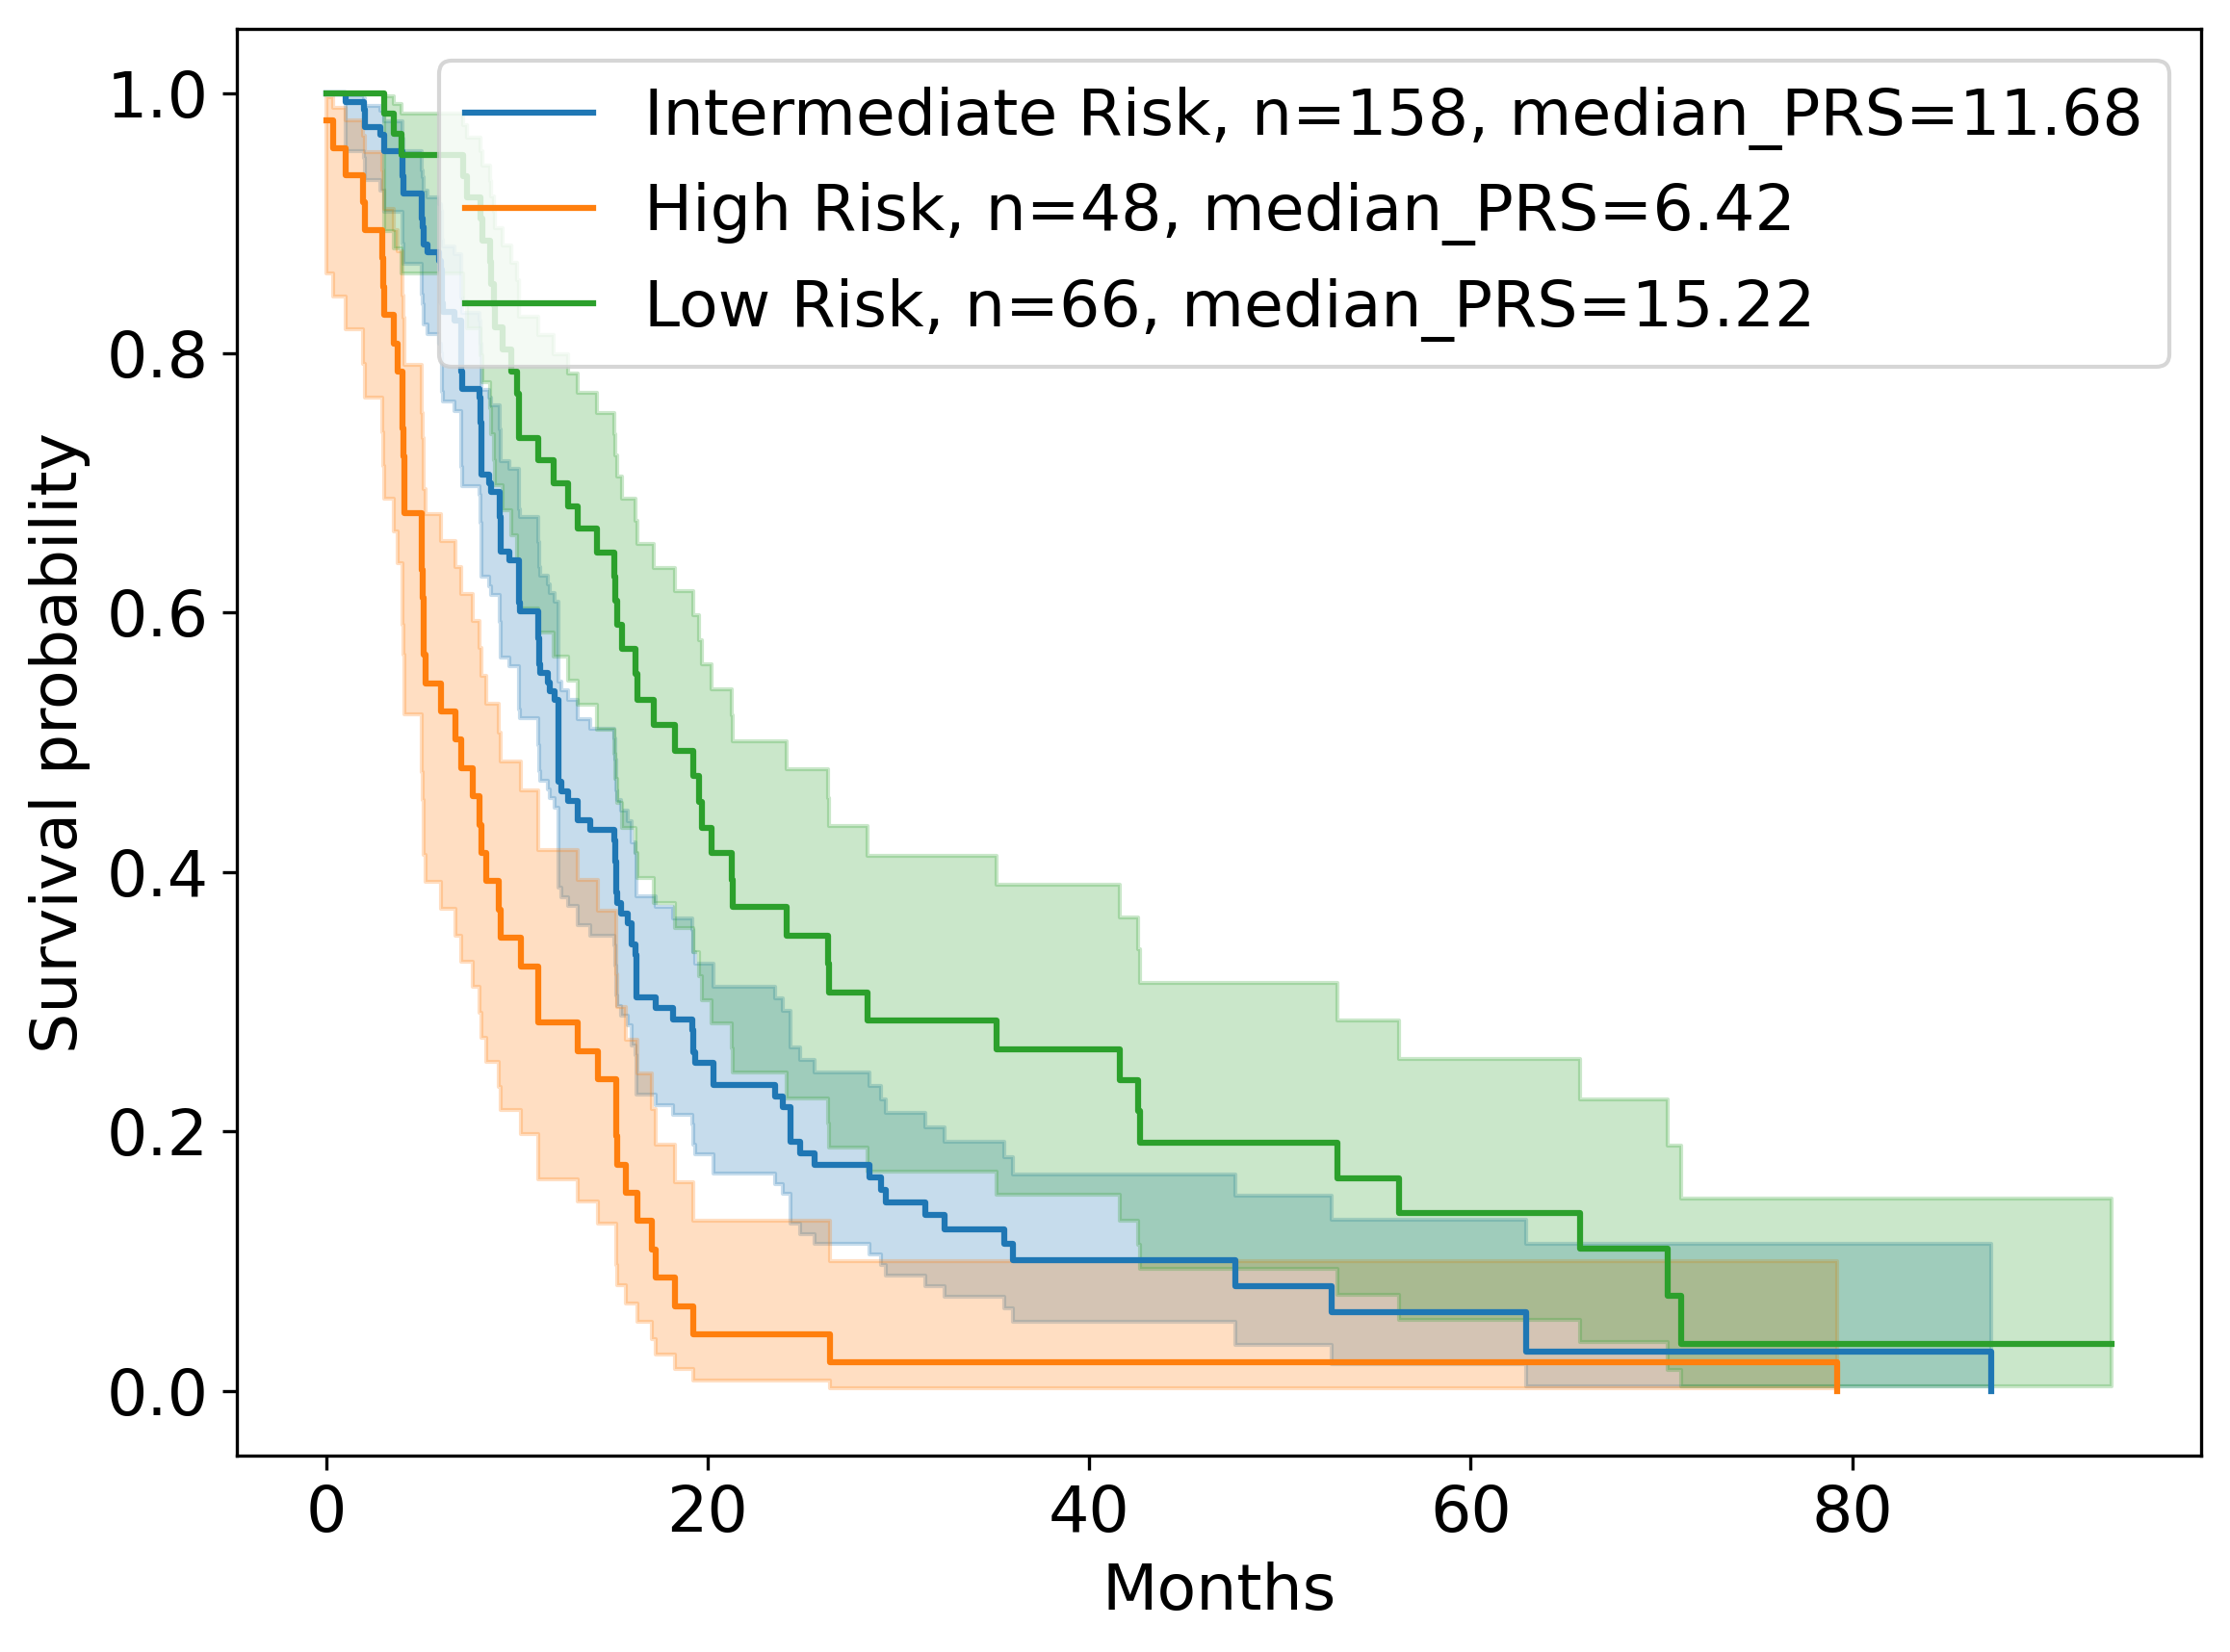

In [42]:
# convert survival time from days to months
time = time / 30.0

# merge data from leaf A and leaf D, and plot KM curve again
leaf_A_D = X.index[(leaves["Leaf A: ce<=7.2 & dose<=19"]) | (leaves["Leaf D: ce>7.2 & kps>80"])]
leaf_A_D_risk_scores = risk_scores[leaf_A_D]

print("Average risk score for Leaf A+D:", leaf_A_D_risk_scores.mean(), "standard deviation:", leaf_A_D_risk_scores.std())
# %%
# plot KM curve for leaf A+D, leaf B and leaf C
kmf = KaplanMeierFitter()
plt.figure(dpi=300)
groups = []
# Leaf A+D
ids = leaf_A_D
groups.append(pd.Series("Leaf A+D", index=ids))
PRS = pd.Series(df["Survival Time (days)"], index=ids)/30.0
median_PRS = np.median(PRS)
label = f"Intermediate Risk, n={len(ids)}, median_PRS={median_PRS:.2f}"
kmf.fit(durations=time.loc[ids], event_observed=event.loc[ids], label=label)
kmf.plot(ci_show=True)
# Leaf C
ids = X.index[leaves["Leaf C: ce>7.2 & kps<=80"]]
groups.append(pd.Series("Leaf C", index=ids))
risk_scores_leaf_C = leaf_risk_dict_mapped["Leaf C: ce>7.2 & kps<=80"]
PRS = pd.Series(df["Survival Time (days)"], index=ids)/30.0
median_PRS = np.median(PRS)
label = f"High Risk, n={len(ids)}, median_PRS={median_PRS:.2f}"
kmf.fit(durations=time.loc[ids], event_observed=event.loc[ids], label=label)
kmf.plot(ci_show=True)     
# Leaf B
ids = X.index[leaves["Leaf B: ce<=7.2 & dose>19"]]
groups.append(pd.Series("Leaf B", index=ids))
risk_scores_leaf_B = leaf_risk_dict_mapped["Leaf B: ce<=7.2 & dose>19"]
PRS = pd.Series(df["Survival Time (days)"], index=ids)/30.0
median_PRS = np.median(PRS)
label = f"Low Risk, n={len(ids)}, median_PRS={median_PRS:.2f}"
kmf.fit(durations=time.loc[ids], event_observed=event.loc[ids], label=label)
kmf.plot(ci_show=True)
 
plt.xlabel("Months")
plt.ylabel("Survival probability")
plt.legend()
plt.tight_layout()
plt.savefig("KM_curve_risk_groups.tif", dpi=300)

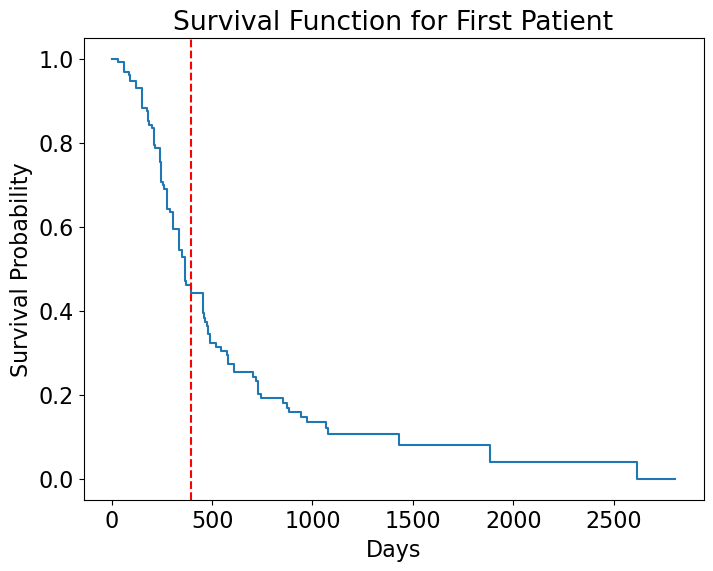

In [43]:
# plot survival curve for the first patient
surv_func = surv_tree.predict_survival_function(X.iloc[[0]])
for fn in surv_func:
    plt.step(fn.x, fn.y, where="post")
# plot actual survival curve
actual_times = df.iloc[0]["Survival Time (days)"]
actual_event = df.iloc[0]["Event Observed"]
plt.axvline(x=actual_times, color="r", linestyle="--", label="Actual Survival Time")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.title("Survival Function for First Patient")
plt.show()

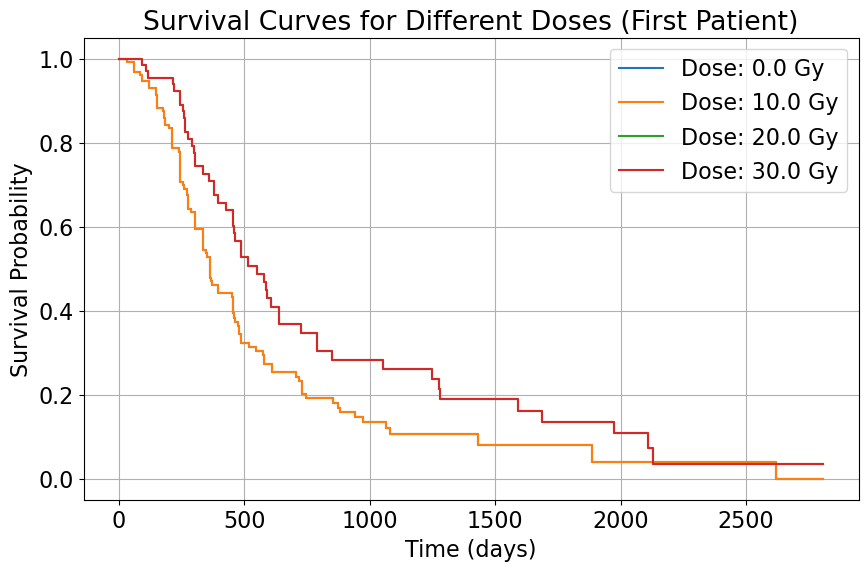

In [44]:
# Evaluate concordance index
c_index = concordance_index_censored(df["Event Observed"], df["Survival Time (days)"], risk_scores)
# print("Concordance Index:", c_index[0]) 

# predict survival function for a given patient and dose
def best_dose_by_survival_at_t(surv_tree, x0, doses, t_star):
    S = []
    for d in doses:
        x0_dose = x0.copy()
        x0_dose["srs_dose_gy"] = d
        surv_func = surv_tree.predict_survival_function(x0_dose)
        # print(surv_func)
        S_t = surv_func[0](t_star)  # survival probability at time t_star
        S.append(S_t)
        # print(S_t)
    S = np.array(S)
    best_dose = doses[np.argmax(S)]
    return best_dose, S.max(), S

# predict survival time based on different doses, draw survival curve
def best_dose_by_survival_curve(surv_tree, x0, doses):
    S = []
    for d in doses:
        x0_dose = x0.copy()
        x0_dose["srs_dose_gy"] = d
        surv_func = surv_tree.predict_survival_function(x0_dose)
        S.append(surv_func[0])
    return doses, S
# Example usage:
# dose grid (choose clinically valid bounds/step)
doses = np.linspace(0, 30, 61)  # 0..70 Gy in 0.5 Gy steps


x0 = X.iloc[[0]].copy()
best_dose, best_survival, survival_all = best_dose_by_survival_at_t(surv_tree, x0, doses, t_star=180)
doses, survival_funcs = best_dose_by_survival_curve(surv_tree, x0, doses)
plt.figure(figsize=(10, 6))
for i, d in enumerate(doses[::20]):  # plot every 20th dose
    plt.step(survival_funcs[i*20].x, survival_funcs[i*20].y, where="post", label=f"Dose: {d} Gy")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Survival Curves for Different Doses (First Patient)")
plt.legend()
plt.grid()
plt.show()


# Methodology

## Study Design and Patient Population

This retrospective study analyzed patients with recurrent glioblastoma multiforme who underwent stereotactic radiosurgery (SRS) treatment. Patient data included clinical variables, treatment parameters, and survival outcomes. The study aimed to develop a survival prediction model and optimize SRS dosing using decision tree analysis.

## Data Collection and Variables

The following clinical and treatment variables were collected for analysis:
- **Age at diagnosis** (years)
- **Karnofsky Performance Status (KPS)** before SRS treatment
- **Pre-SRS contrast-enhancing tumor volume** (cm³, including necrosis)
- **SRS dose** (Gy)
- **Survival time** (days from SRS to death or last follow-up)
- **Event status** (death = 1, censored = 0)

Data preprocessing included conversion of survival times from days to months for analysis and removal of any incomplete records.

## Survival Tree Construction

A survival decision tree was constructed using the scikit-survival package with the following specifications:
- **Criterion**: Log-rank test for node splitting
- **Minimum samples per split**: Default parameters
- **Maximum tree depth**: Optimized to prevent overfitting

The tree was designed to identify clinically relevant cutoff points for patient stratification based on the input variables. Clinical cutoffs were established at:
- **Tumor volume**: 7.2 cm³
- **SRS dose**: 19 Gy  
- **KPS**: 80 points

## Risk Stratification

Based on the survival tree analysis, patients were stratified into distinct risk groups:

**Leaf A (Low-Intermediate Risk)**: Tumor volume ≤ 7.2 cm³ AND SRS dose ≤ 19 Gy
**Leaf B (Low Risk)**: Tumor volume ≤ 7.2 cm³ AND SRS dose > 19 Gy
**Leaf C (High Risk)**: Tumor volume > 7.2 cm³ AND KPS ≤ 80
**Leaf D (Intermediate Risk)**: Tumor volume > 7.2 cm³ AND KPS > 80

For subsequent analysis, Leaf A and Leaf D were combined into an "Intermediate Risk" group due to similar survival characteristics.

## Statistical Analysis

### Survival Analysis
Kaplan-Meier survival curves were constructed for each risk group using the lifelines package. Median survival times with 95% confidence intervals were calculated for each group.

### Comparative Analysis
Between-group survival differences were assessed using:
1. **Log-rank test**: For overall survival comparison between risk groups
2. **Cox proportional hazards regression**: To calculate hazard ratios (HR) with 95% confidence intervals

### Model Performance
The survival tree's predictive performance was evaluated using:
- **Concordance index (C-index)**: Measure of the model's ability to correctly rank patients by survival time

## Dose Optimization Analysis

A dose optimization framework was developed to identify optimal SRS doses for individual patients:

1. **Dose Grid Construction**: A range of clinically relevant doses (0-30 Gy) was evaluated in 0.5 Gy increments
2. **Survival Function Prediction**: For each patient-dose combination, survival probability functions were generated using the trained survival tree
3. **Optimization Criteria**: The optimal dose was defined as the dose maximizing survival probability at a specified time point (180 days)
4. **Visualization**: Survival curves were plotted for different doses to visualize dose-response relationships

## Software and Statistical Packages

All analyses were performed in Python using the following packages:
- **pandas**: Data manipulation and preprocessing
- **numpy**: Numerical computations
- **scikit-survival**: Survival tree construction and concordance index calculation
- **lifelines**: Kaplan-Meier estimation, Cox regression, and log-rank testing
- **matplotlib**: Data visualization
- **graphviz**: Decision tree visualization

## Statistical Significance

Statistical significance was set at p < 0.05 for all analyses. Confidence intervals were calculated at the 95% level for survival estimates and hazard ratios.

## Model Validation

The survival tree model was validated through:
1. Assessment of clinical relevance of identified cutoff points
2. Statistical significance of between-group survival differences
3. Concordance index evaluation for predictive performance
4. Visual inspection of survival curves for clinical plausibility